In [1]:
import os, sys
import matplotlib.pyplot as plt
import math

# change as needed
sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
from OpenVisus import *

def Show(data,width=10):
	ratio=float(data.shape[1])/data.shape[0]
	fig = plt.figure(figsize = (width,width*ratio))
	ax = fig.add_subplot(1,1,1)
	ax.imshow(data, origin='lower')
	plt.show()

Starting OpenVisus C:\projects\OpenVisus\build\RelWithDebInfo\OpenVisus\__init__.py 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)] sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0) ...


Define a python utility to extract arbitrary slices

In [12]:
# utility to extract a slice
def ExtractSlice(db, position,nlevels=1,quality=0, field=None,time=None, bShareMem=False):
    
    if field is None:
        field=db.getField()
    
    if time is None:
        time=db.getTime()
    
    pdim=db.getPointDim()
    max_resolution=db.getMaxResolution()
    
    access=db.createAccess()
    query = db.createPointQuery(position, field , time)

    resolutions=reversed([max_resolution + quality  - pdim*I for I in range(nlevels)])
    resolutions=[it for it in resolutions if it>0]
    for it in resolutions:
        query.end_resolutions.push_back(it)
        
    nsamples=db.guessPointQueryNumberOfSamples(Frustum(),query.logic_position, resolutions[-1])
    query.setPoints(nsamples)         
        
    db.beginPointQuery(query)    

    while query.isRunning():

        if not db.executePointQuery(access, query): break
        data=Array.toNumPy(query.buffer, bShareMem=False) 
        data=data[0,:,:] # it is a slice!
        yield data
        db.nextPointQuery(query)

Extract a arbitrary slice.

Note 1: start always with a slice Z=0 (i.e. a full quad in 2-dimension) and use a Matrix to embed it into the 3-space

Note 2: there is a BUG with clipping planes if you go outside dataset boundaries

Got data (110, 512) float32


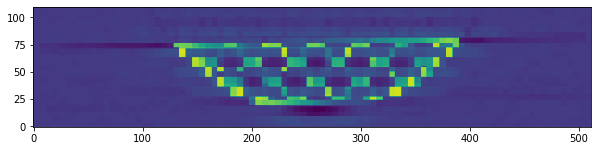

Got data (110, 512) float32


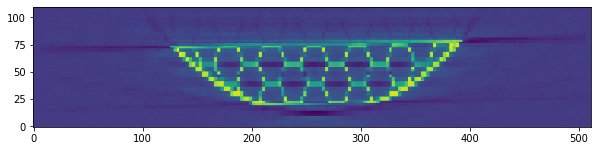

Got data (110, 512) float32


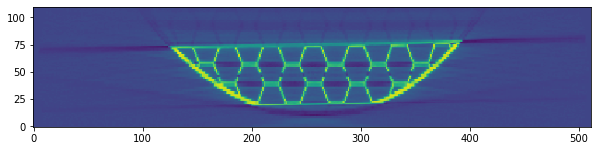

In [16]:
db=LoadDataset(r'D:\GoogleSci\visus_dataset\TALASS\ACAM\honeycomb.idx')
Width,Height,Depth=db.getLogicBox()[1]

"""
Translate(0,62,0)
    RotateX(30)
        Slice@Z=0
"""

T=Matrix.translate(PointNd(0,62,0))
R=Matrix.rotate(4,1,2,math.radians(30))
slice=BoxNd(PointNd(0,0,0),PointNd(Width,Height,0))

for data in ExtractSlice(db, Position(R,T,Position(slice)), nlevels=3, quality=-6):
    print("Got data", data.shape, data.dtype)
    Show(data) 